## Demonstrate the use of dense (DNN) and recurrent (RNN) neural networks to predict time series data

### Data fetching and conversion

In [51]:
import os
import numpy as np
import pandas as pd

# read data from file
filepath = os.path.join('data', 'climate', 'jena_climate_2009_2016.csv')

with open(filepath, 'r') as fs:
    data = fs.read()

# convert the data
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### Exploratory data analysis

            p (mbar)       T (degC)       Tpot (K)    Tdew (degC)         rh (%)   VPmax (mbar)   VPact (mbar)   VPdef (mbar)      sh (g/kg)  H2OC (mmol/mol)   rho (g/m**3)       wv (m/s)  max. wv (m/s)       wd (deg)
count  420551.000000  420551.000000  420551.000000  420551.000000  420551.000000  420551.000000  420551.000000  420551.000000  420551.000000    420551.000000  420551.000000  420551.000000  420551.000000  420551.000000
mean      989.212776       9.450147     283.492743       4.955854      76.008259      13.576251       9.533756       4.042412       6.022408         9.640223    1216.062748       1.702224       3.056555     174.743738
std         8.358481       8.423365       8.504471       6.730674      16.476175       7.739020       4.184164       4.896851       2.656139         4.235395      39.975208      65.446714      69.016932      86.681693
min       913.600000     -23.010000     250.600000     -25.010000      12.950000       0.950000       0.790000       0.000000   

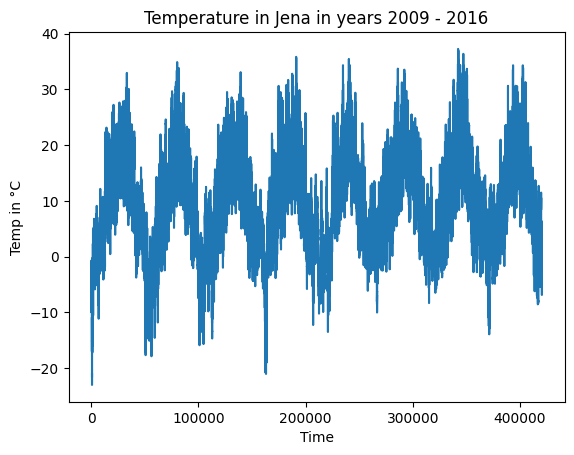

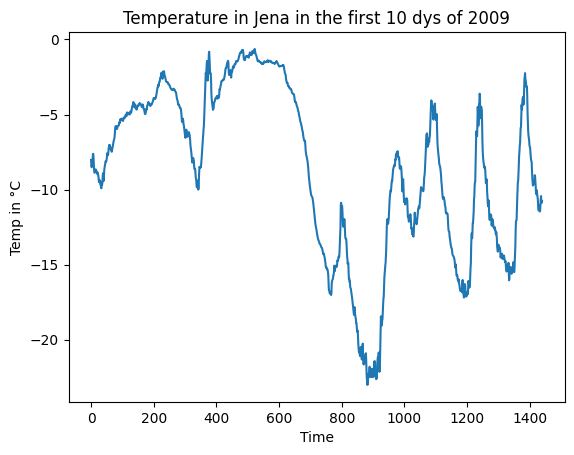

In [56]:
from matplotlib import pyplot as plt

%matplotlib inline

# override default width of printed output
# pd.set_option('display.width', 500)

d = pd.read_csv(filepath)
print(d.describe())
print(d.dtypes)

# try out something of recent interest -
# climate change in terms of temperature
temp = float_data[:, 1]

# investigate temperature fluctuations
plt.plot(range(len(temp)), temp)
plt.title('Temperature in Jena in years 2009 - 2016')
plt.xlabel('Time')
plt.ylabel('Temp in °C')
plt.show()

# first 10 days
plt.plot(range(1440), temp[:1440])
plt.title('Temperature in Jena in the first 10 dys of 2009')
plt.xlabel('Time')
plt.ylabel('Temp in °C')
plt.show()

### Data sampling

In [40]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

# normalize the data before feeding
# the neural networks
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def batch_generator(
    data, lookback, delay, min_index, max_index,
    shuffle=False, batch_size=128, step=6):
    """Generates batches of time series data for training.
    
    Parameters:
    -----------
    data (numpy.ndarray):
    The dataset from which to generate batches.
    
    lookback (int):
    The number of timesteps to look back for each sample.
    
    delay (int):
    The number of timesteps in the future to predict.
    
    min_idx (int):
    The minimum index in the data to consider for generating batches.
    
    max_idx (int or None):
    The maximum index in the data to consider for generating batches.
    If None, it is set to len(data) - delay - 1.
    
    shuffle (bool):
    Whether to shuffle the samples or draw them
    in chronological order. Default is False.
    
    batch_size (int):
    The number of samples per batch. Default is 128.
    
    step (int):
    The period, in timesteps, between successive samples. Default is 6.
    
    Yields:
    -------
    tuple: A tuple containing:
      - samples (numpy.ndarray): A batch of input samples.
      - targets (numpy.ndarray): The corresponding targets for the input samples.
    """
    
    if max_index is None:
        max_index = len(data) - delay - 1
        
    i = min_index + lookback
    
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

lookback = 1440 # recent 10 days
step = 6 # sample stepping in one data point (6 per hour)
delay = 144 # prediction delay 24 h in the future
batch_size = 128 # samples per batch

# training data generator
train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size
)

# testing data generator
val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size
)

# validation data generator
test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size
)

# number of steps to draw from validation generator
# in order to see the whole validation set
val_steps = (300000 - 200001 - lookback) // batch_size

# number of steps to draw from testing generator
# in order to see the whole validation set
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### Model compilation

In [35]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Input(shape=(lookback // step, float_data.shape[-1]))) # RGB images, hence 3 channels
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss='mae',  # mean absolute error should be most suitable for regressive problem
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 3360)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │         107,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 107,585 (420.25 KB)

 Trainable params: 107,585 (420.25 KB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [36]:
history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.0000e+00 - loss: 1.8920 - val_accuracy: 0.0000e+00 - val_loss: 0.4216
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.0000e+00 - loss: 0.4879 - val_accuracy: 0.0000e+00 - val_loss: 0.3545
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.0000e+00 - loss: 0.2923 - val_accuracy: 0.0000e+00 - val_loss: 0.2978
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.0000e+00 - loss: 0.2667 - val_accuracy: 0.0000e+00 - val_loss: 0.3389
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.0000e+00 - loss: 0.2526 - val_accuracy: 0.0000e+00 - val_loss: 0.3049
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.0000e+00 - loss: 0.2469 - val_accuracy: 0.0000e+00 - val_loss: 0.3129
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.0000e+00 - loss: 0.2354 - val_accuracy: 0.0000e+00 - val_loss: 0.3152
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8

### Model evaluation

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.3637
Test loss: 0.3475 Test accuracy: 0.0


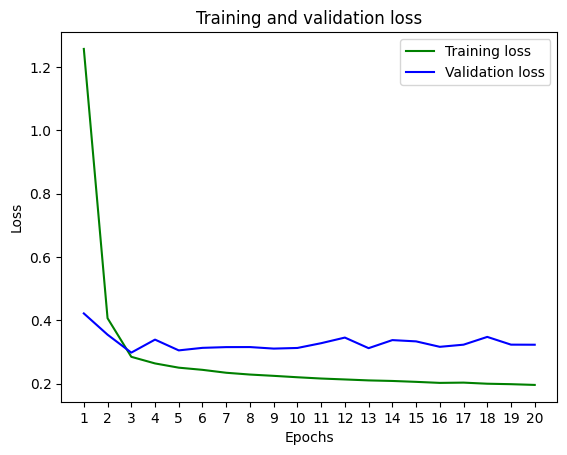

In [46]:
# evaluate the model in terms of accuracy and loss
test_loss, test_acc = model.evaluate(test_gen, steps=50)
print('Test loss:', round(test_loss, 4), 'Test accuracy:', round(test_acc, 4))

history_loss = history.history['loss']
history_val_loss = history.history['val_loss']
epochs=range(1, len(history_loss) + 1)

plt.plot(epochs, history_loss, 'g', label='Training loss')
plt.plot(epochs, history_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()